<div align="right"><a href="http://norvig.com">Peter Norvig</a><br><a href="https://github.com/norvig/pytudes">pytudes</a><br>March 2019</div>

# Dice Baseball

The [March 22, 2019 Riddler](https://fivethirtyeight.com/features/can-you-turn-americas-pastime-into-a-game-of-yahtzee/) asks us to simulate baseball using probabilities from a 19th century dice game.  There were some choices to make that were left unspecified in the rules; these are my choices (your choices may differ):

* On a `b`-base hit, runners advance `b` bases, except that a runner on second scores on a 1-base hit.
* On an "out at first", all runners advance one base.
* On a double play, the runner on first is out if there is one, otherwise a runner on second, otherwise a runner on third, otherwise it is only a single out.
* On a fly out, a runner on third scores; other runners do not advance.
* On an error all runners advance one base. (*Note: in an earlier version, I treated an error as a single, meaning that a runner would score from second on an error, which seems wrong. Under that interpretation, teams score about 0.05 runs more per game.*)

I also made some choices about the implementation:
- I wanted to have one event per batter, so I don't allow "strike" as an event. Rather I compute the probability of a strikeout event (i.e. getting three "strike" dice rolls in a row before getting another event) as `(7/36)**3`, and check for that.
- Note that a die roll such as (1, 1) is a 1/36 event, whereas (1, 2) is a 2/36 event, because it is also (2, 1).
- I'll represent events with the following one letter codes:
  - `K`, `O`, `o`, `f`, `D`: strikeout, foul out, out at first, fly out, double play
  - `1`, `2`, `3`, `4`: single, double, triple, home run
  - `E`, `B`: error, base on balls
- I'll keep track of runners with a list of occupied bases; `runners = [1, 2]` means runners on first and second.
- A runner who advances to base 4 or higher has scored a run (unless there are already 3 outs).
- The function `inning` simulates a half inning and returns the number of runs scored.
- I'll run the simulation 1 million times and store the resulting scores in `innings`.
- To simulate a game I just sample 9 elements of `innings` and sum them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [2]:
def inning(events='2111111EEBBOOooooooofffffD334', strikes=7, verbose=False) -> int:
    "Simulate a random inning and return number of runs scored."
    n = len(events) + strikes # With 2 dice, n = 36
    PK = (strikes / n) ** 3   # The probability of a strikeout
    outs = runs = 0           # Inning starts with no outs and no runs,
    runners = []              # ... and with nobody on base
    while True:
        x = 'K' if random.random() <= PK else random.choice(events)
        if verbose: print(f'outs: {outs}, runs: {runs}, runners: {runners}, event: {x}')
        if x in 'KOofD': # batter is out: strikeout, foul out, out at first, fly out, double play
            outs += 1
            if x == 'D' and runners: # double play
                runners.remove(min(runners))
                outs += 1
            elif x == 'o': # out at first (other runners advance)
                runners = [r+1 for r in runners]
            elif x == 'f' and 3 in runners: # fly out; runner on 3rd scores
                runners.remove(3)
                runs += 1
        else: # batter reaches base safely
            runners.append(0)
            if x in '1234': # single, double, triple, homer
                runners = [r + int(x) + (r == 2) for r in runners]
            elif x == 'E': # error
                runners = [r + 1 for r in runners]
            elif x == 'B': # base on balls
                runners = [r + all(b in runners for b in range(r)) for r in runners]
        if outs >= 3:
            return runs
        else: # See if anybody scored
            runs += sum(r >= 4 for r in runners)
            runners = [r for r in runners if r < 4]

Let's peek at some random innings:

In [3]:
inning(verbose=True)

outs: 0, runs: 0, runners: [], event: 4
outs: 0, runs: 1, runners: [], event: E
outs: 0, runs: 1, runners: [1], event: 1
outs: 0, runs: 1, runners: [2, 1], event: 4
outs: 0, runs: 4, runners: [], event: 3
outs: 0, runs: 4, runners: [3], event: o
outs: 1, runs: 5, runners: [], event: o
outs: 2, runs: 5, runners: [], event: f


5

In [4]:
inning(verbose=True)

outs: 0, runs: 0, runners: [], event: o
outs: 1, runs: 0, runners: [], event: D
outs: 2, runs: 0, runners: [], event: 1
outs: 2, runs: 0, runners: [1], event: E
outs: 2, runs: 0, runners: [2, 1], event: 3
outs: 2, runs: 2, runners: [3], event: o


2

In [5]:
inning(verbose=True)

outs: 0, runs: 0, runners: [], event: f
outs: 1, runs: 0, runners: [], event: 1
outs: 1, runs: 0, runners: [1], event: B
outs: 1, runs: 0, runners: [2, 1], event: B
outs: 1, runs: 0, runners: [3, 2, 1], event: 1
outs: 1, runs: 2, runners: [2, 1], event: 3
outs: 1, runs: 4, runners: [3], event: o
outs: 2, runs: 5, runners: [], event: K


5

That looks good.

Now, simulate a million innings, and then sample from them to simulate a million nine-inning games:

In [6]:
N = 1000000
innings = [inning() for _ in range(N)]
games = [sum(random.sample(innings, 9)) for _ in range(N)]

Finally, display the mean number of runs scored per team per nine-inning game, along with a histogram:

14.959092

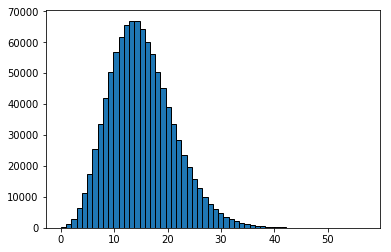

In [7]:
plt.hist(games, ec='black', bins=max(games)-min(games)+1)
sum(games) / N